In [16]:
import pandas as pd
import matplotlib.pyplot as plt
#import neurokit2 as nk # didn't need it afterall, but worth looking into
import numpy as np

In [17]:
# read the dataset in
filename = "Output3.txt" # Mathias (white male) phisical activity
#filename = "1.txt" # Anna (small finger) annoying game
df = pd.read_csv(f"data/{filename}", # too lazy for pahlib 
                sep='\t', #stupid separator. What's wrong with comma?
                names = ["Time", "ID", "blah", "BP", "GSR", "Phase"] # Let's give some nice column names
                ).drop(columns=["blah"]) # We drop "Acquired Data" - I think it's spelled "Aquired" though...
df['Time'] = pd.to_datetime(df["Time"])
print('Num samples:', len(df))
df = df.set_index("Time")
sampling_rate = df.groupby(pd.Grouper(freq="1s")).count().mode()['ID'].values[0]
print('sample rate:', sampling_rate)
n = len(df)
df['BP'] = df['BP'].rolling('50ms').mean().fillna(method='bfill')
df


Num samples: 36856
sample rate: 100


,ID,BP,GSR,Phase
Time,,,,
2023-05-05 13:27:33.593,1,30820.000000,11808,NaN
2023-05-05 13:27:33.603,2,30786.000000,11852,NaN
2023-05-05 13:27:33.626,3,30749.333333,11810,NaN
2023-05-05 13:27:33.628,4,30708.750000,11850,NaN
2023-05-05 13:27:33.628,5,30667.000000,11809,NaN
...,...,...,...,...
2023-05-05 13:33:45.458,36852,32270.400000,11727,NaN
2023-05-05 13:33:45.491,36853,32291.333333,11690,NaN
2023-05-05 13:33:45.493,36854,32330.000000,11725,NaN


In [18]:
df['Phase'].unique()

array([nan, 'baseline', 'stress', 'experiment', 'control'], dtype=object)

# HR

offset 895.5333333333334


/tmp/ipykernel_1693/2360318943.py:25: FutureWarning: ['Phase'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  peaks = df.groupby('Periods').agg(f)


[]

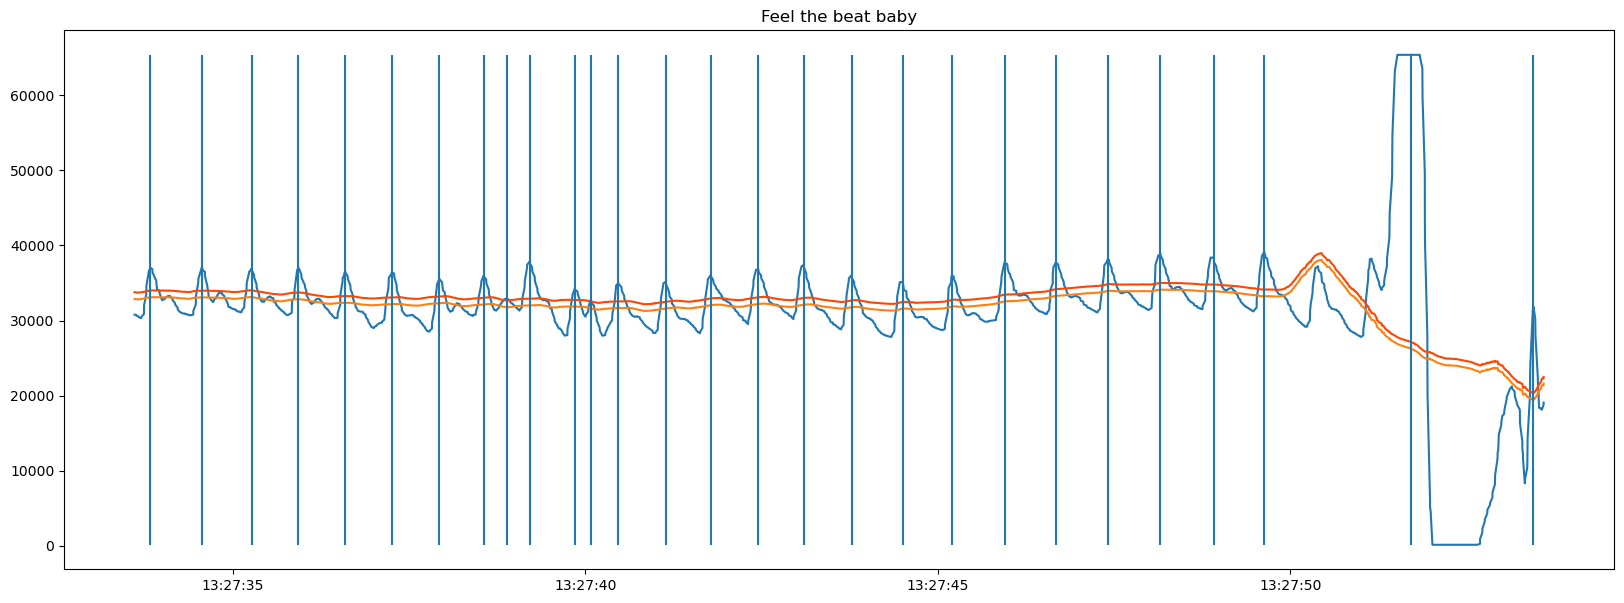

In [19]:
def f(x):
    if x.name == 'BP':
        return x.idxmax()
    else:
        return x.max()
sample = df[['BP']]
rolling_mean = sample.rolling('3s', center=True).mean()

plt.figure(figsize=(20, 7))
plt.title("Feel the beat baby")
start_idx = 1
plot_n = 2000
plt.plot(sample[start_idx:start_idx+plot_n:])

resting_range = sample.values[-2000:-1000].max() - sample.values[-2000:-1000].min() #proxy for amplitude - let's pray there's valid data in this range
offset_scaler = 6 # kindof arbitrary, might need adjustment
offset = resting_range / offset_scaler # we need to offset the running mean to avoid counting a pulse at the half pulse (only local absolute max counts)
print("offset", offset)
plt.plot(rolling_mean[start_idx:start_idx+plot_n])
plt.plot(rolling_mean[start_idx:start_idx+plot_n]+offset, color='orangered')


df['Onset'] = sample > rolling_mean + offset
df['Periods'] = np.cumsum(df['Onset'] != df['Onset'].shift(1))
peaks = df.groupby('Periods').agg(f)
peaks = peaks.loc[peaks['Onset']]
peaks.loc[peaks['Onset']]

plt.vlines(peaks['BP'].loc[(peaks['BP'] > sample.index[start_idx]) & (peaks['BP'] < sample.index[start_idx+plot_n])], ymin=sample.min(), ymax=sample.max())
plt.plot()


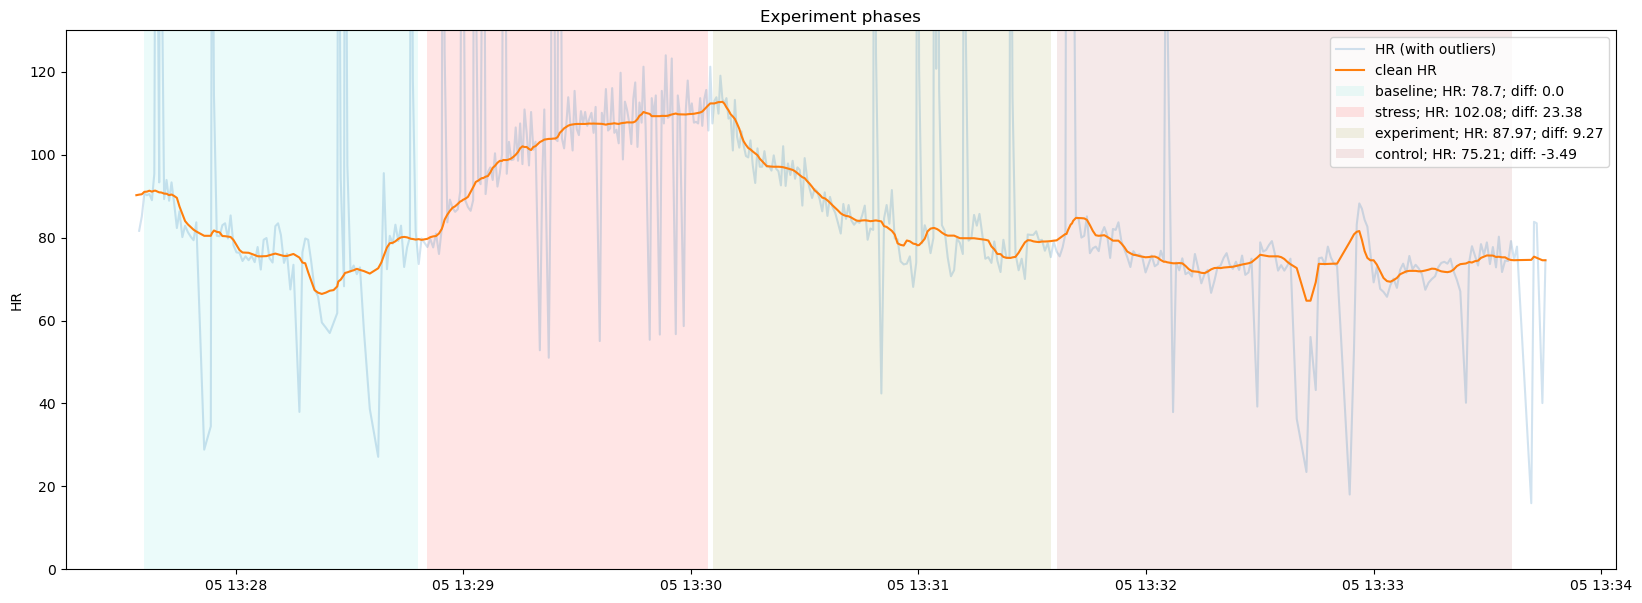

In [20]:
# this is how you calculate heart rate:
#https://www.researchgate.net/figure/Heart-rate-is-derived-from-measures-of-blood-volume-pulse-by-measuring-the-interbeat_fig3_259560204
hr = pd.DataFrame({'HR': 60/peaks['BP'].diff().dt.total_seconds(), 'Time': peaks['BP']})
hr = hr.set_index('Time')
hr['Phase'] = np.nan
hr['HR_clean'] = hr['HR'].rolling('10s', center=True).median().rolling('2s').mean()
baseline_mean = 0
plt.figure(figsize=(20, 7))
plt.title("Experiment phases")
plt.ylabel("HR")
plt.ylim(0, 130)
plt.plot(hr.index, hr['HR'], alpha=0.2, label='HR (with outliers)')
plt.plot(hr.index, hr['HR_clean'], label='clean HR')
col = {'baseline': 'turquoise', 'stress':'red', 'experiment':'olive', 'control':'brown'}
summary = {'Phase': [], 'mean_HR': [], 'diff_from_baseline': []}
for phase, colour in col.items():
    if not phase in df['Phase'].unique():
        continue
    start_phase = df.loc[df['Phase']==phase].index.min()
    end_phase = df.loc[df['Phase']==phase].index.max()
    phase_mask = (hr.index > start_phase) & (hr.index < end_phase)
    mean_hr = hr['HR_clean'].loc[phase_mask].mean()
    if phase == 'baseline':
        baseline_mean = mean_hr
    hr['Phase'].loc[phase_mask] = phase
    plt.axvspan(start_phase, 
                end_phase, 
                facecolor=colour, alpha=0.1, label=f"{phase}; HR: {mean_hr.round(2)}; diff: {(mean_hr-baseline_mean).round(2)}")
    summary['Phase'].append(phase)
    summary['mean_HR'].append(mean_hr)
    summary['diff_from_baseline'].append(mean_hr-baseline_mean)
plt.legend()

In [21]:
pd.DataFrame(summary)

,Phase,mean_HR,diff_from_baseline
0,baseline,78.702065,0.000000
1,stress,102.078035,23.375970
2,experiment,87.971121,9.269057
3,control,75.208623,-3.493442


# GSR

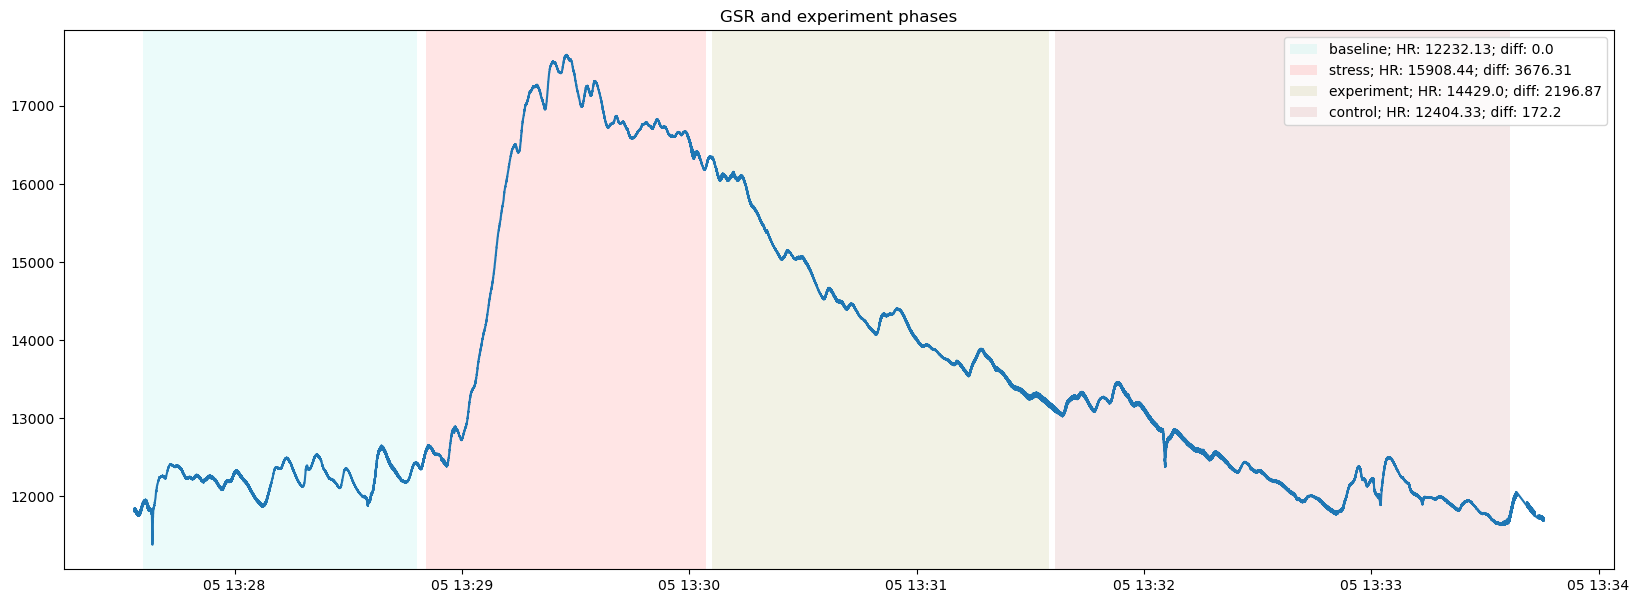

In [22]:
plt.figure(figsize=(20, 7))
plt.title("GSR and experiment phases")
plt.plot(df.index, df['GSR'])
col = {'baseline': 'turquoise', 'stress':'red', 'experiment':'olive', 'control':'brown'}
for phase, colour in col.items():

    start_phase = df.loc[df['Phase']==phase].index.min()
    end_phase = df.loc[df['Phase']==phase].index.max()

    mean_gsr = df['GSR'].loc[(df.index > start_phase) & (df.index < end_phase)].mean().round(2)
    if phase == 'baseline':
        baseline_mean = mean_gsr
    
    plt.axvspan(start_phase, 
                end_phase, 
                facecolor=colour, alpha=0.1, label=f"{phase}; HR: {mean_gsr}; diff: {(mean_gsr-baseline_mean).round(2)}")



    plt.legend()